In [1]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append(Path('../src'))
from heisenberg_hamiltonian_antiferro import HeisenbergHamiltonainAntiferro
from bf_quantum_state import BFQuantumState

In [2]:
#global variables
ratios_h_j = np.array([0.01, 0.02, 0.05, 0.1,
                           0.2, 0.5, 1, 2, 5, 10, 20, 50, 100], dtype=float)
save_direc_eigs = Path('data/Diagonal_hamiltonian/heisenberg_eigenvalues_first_dict.npy')
save_direc_groundstate = Path('data/Diagonal_hamiltonian/heisenberg_groundstate_dict.npy')

In [3]:
# periodic boundary conditions and antiferromagnetic case

qubit_numbers = np.array([14])
#creating nested dictionaries
energy_eig_vals_dict = {}
ground_state_dict = {}
J_val = 1 #antiferromagnetic case
boundary = 'periodic'
for i in range(0, np.size(qubit_numbers)):
    print('starting number of qubits: ' + str(qubit_numbers[i]))
    energy_eig_vals_dict[str(qubit_numbers[i])] = {}
    ground_state_dict[str(qubit_numbers[i])] = {}
    for j in range(0, np.size(ratios_h_j)):
        energy_eig_vals, eigvecs = HeisenbergHamiltonainAntiferro(qubit_numbers[i], ratios_h_j[j], J_val, boundary).diagonalize(1, True)
        ground_state = pt.tensor(eigvecs[:, 0])
        energy_eig_vals_dict[str(qubit_numbers[i])][str(ratios_h_j[j])] = energy_eig_vals
        ground_state_dict[str(qubit_numbers[i])][str(ratios_h_j[j])] = ground_state
np.save(save_direc_eigs, energy_eig_vals_dict)
np.save(save_direc_groundstate, ground_state_dict)

starting number of qubits: 14


We load the stored energies and ground states.

In [3]:
energy_dict = np.load(save_direc_eigs, allow_pickle='TRUE')
energy_dict = energy_dict.item()
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()

We plot the ground state energy against the ratio $\frac{h}{J}$.

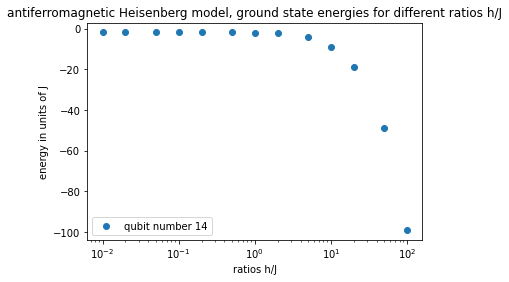

In [4]:
qubit_num = np.array([14])

for i in range(0, np.size(qubit_num)):
    energy = np.zeros(np.size(ratios_h_j))
    for j in range(0, np.size(ratios_h_j)):
        energy[j] = energy_dict[str(qubit_num[i])][str(ratios_h_j[j])][0]
    energy_per_qubit = energy / qubit_num[i]
    plt.scatter(ratios_h_j, energy_per_qubit, label='qubit number ' + str(qubit_num[i]))
    plt.xscale('log')
    plt.xlabel('ratios h/J')
    plt.ylabel('energy in units of J')
    plt.legend()
    plt.title('antiferromagnetic Heisenberg model, ground state energies for different ratios h/J')



Now we predict these energies using classical shadows. We first do the necessary
randomized Pauli basis measurements.

In [6]:
qubit_num = np.array([14])
# # the generation of a measurement procedure becomes very slow when num_of_measurements becomes big
# (~1000). In the case of the ising model it is alright to proceed by using batches because we only
# measure two different Pauli strings. We have to remove this batched procedure though when
# dealing with more complicated systems where we have to measure more than 100 different Pauli Strings
# for now we form batches of 100 measurements
# num of measurements has to be a multiple of 100
num_of_measurements = 100000
measurement_methods = np.array(['derandomized', 'randomized'])
for i in range(np.size(qubit_num)):
    for j in range(np.size(ratios_h_j)):
        ground_state = ground_state_dict[str(qubit_num[i])][str(ratios_h_j[j])]
        print('starting ratio h/J = ' + str(ratios_h_j[j]))
        for l in range(0, 2):
            observables = HeisenbergHamiltonainAntiferro(qubit_num[i], ratios_h_j[j], 1, 'periodic').observables_for_energy_estimation()
            measurement_procedure, measurement_index = BFQuantumState(qubit_num[i],
                                ground_state).measurement_shadow(num_of_measurements, measurement_methods[l], observables)
            save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_heisenberg_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num[i])+'_method_'+measurement_methods[l]+'.npy')
            save_direc_index = Path('data/shadow_measurements/measurement_heisenberg_index_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num[i])+'_method_'+measurement_methods[l]+'.npy')
            np.save(save_direc_procedure, measurement_procedure)
            np.save(save_direc_index, measurement_index)


starting ratio h/J = 0.01
starting ratio h/J = 0.02
starting ratio h/J = 0.05
starting ratio h/J = 0.1
starting ratio h/J = 0.2
starting ratio h/J = 0.5
starting ratio h/J = 1.0
starting ratio h/J = 2.0
starting ratio h/J = 5.0
starting ratio h/J = 10.0
starting ratio h/J = 20.0
starting ratio h/J = 50.0
starting ratio h/J = 100.0


In [5]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

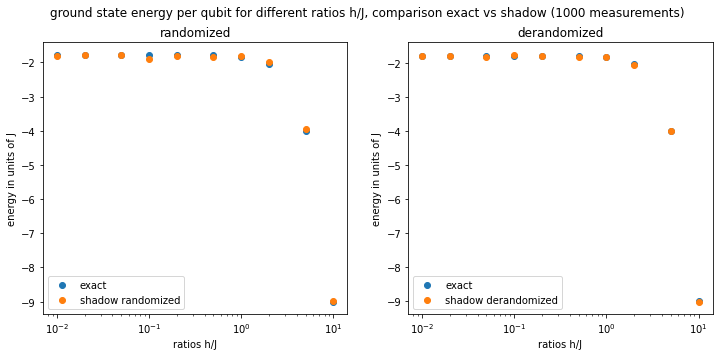

In [6]:
qubit_num = 14
num_of_measurements = 1000
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
fig.suptitle('ground state energy per qubit for different ratios h/J, comparison exact vs shadow (' + str(num_of_measurements) + ' measurements)')
measurement_methods = ['randomized', 'derandomized']
for i in range(0, 2):
    energy_shadow = np.zeros(np.size(ratios_h_j))
    energy_brute = np.zeros(np.size(ratios_h_j))
    for j in range(0, np.size(ratios_h_j)):
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_heisenberg_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[i]+'.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_heisenberg_index_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[i]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[0:num_of_measurements,:],
                                                                  measurement_index[0:num_of_measurements], qubit_num)
        energy_shadow[j] = HeisenbergHamiltonainAntiferro(qubit_num, ratios_h_j[j],
                                             1, 'periodic').energy_shadow(None, num_of_measurements, measurement_methods[i], measurements)
        energy_brute[j] = energy_dict[str(qubit_num)][str(ratios_h_j[j])][0]
    axs[i].scatter(ratios_h_j[:-3], energy_brute[:-3] / qubit_num, label = 'exact')
    axs[i].scatter(ratios_h_j[:-3], energy_shadow[:-3] / qubit_num, label = 'shadow ' + measurement_methods[i])
    axs[i].set(xscale='log', xlabel='ratios h/J',
                      ylabel='energy in units of J')
    axs[i].set_title(measurement_methods[i])
    axs[i].legend()

Now we would like to see the absolute and relative error in the prediction.

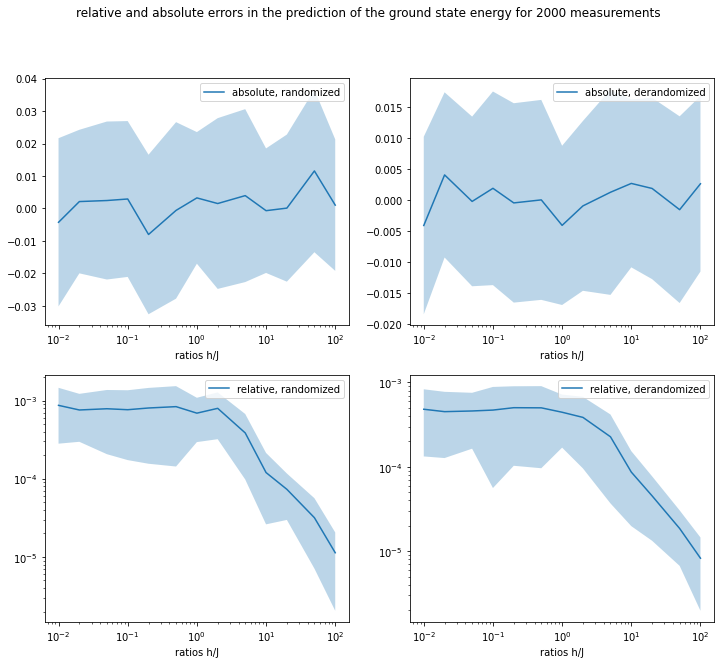

In [9]:
num_of_measurements = 2000
batches = 50
error_types = ['absolute', 'relative']
measurement_methods = ['randomized', 'derandomized']
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.suptitle('relative and absolute errors in the prediction of the ground state energy for ' + str(num_of_measurements) + ' measurements')

for i in range(0,2):
    for j in range(0,2):
        error = np.zeros((batches, np.size(ratios_h_j)))
        for b in range(0, batches):
            for k in range(0, np.size(ratios_h_j)):
                energy_brute = energy_dict[str(qubit_num)][str(ratios_h_j[k])][0]
                save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_heisenberg_ratio_'+\
                              str(ratios_h_j[k])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[j]+'.npy')
                save_direc_index = Path('data/shadow_measurements/measurement_heisenberg_index_ratio_'+\
                              str(ratios_h_j[k])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[j]+'.npy')
                measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
                measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[b*num_of_measurements:(b+1)*num_of_measurements,:],
                                                                          measurement_index[b*num_of_measurements:(b+1)*num_of_measurements], qubit_num)
                energy_shadow = HeisenbergHamiltonainAntiferro(qubit_num, ratios_h_j[k],
                                                 1, 'periodic').energy_shadow(None, num_of_measurements, measurement_methods[j], measurements)
                if error_types[i] == 'absolute':
                    error[b,k] = (energy_shadow - energy_brute) / qubit_num
                if error_types[i] == 'relative':
                    error[b,k] = np.abs(energy_brute - energy_shadow) / qubit_num / np.abs(energy_brute)
        error_mean = np.mean(error, axis = 0)
        error_std = np.std(error, axis = 0)
        axs[i, j].errorbar(ratios_h_j, error_mean, label = error_types[i] + ', ' + measurement_methods[j])
        axs[i, j].fill_between(ratios_h_j, error_mean - error_std, error_mean + error_std, alpha = 0.3)
        if error_types[i] == 'absolute':
            axs[i, j].set(xscale='log', xlabel='ratios h/J')
        if error_types[i] == 'relative':
            axs[i, j].set(xscale='log', yscale = 'log', xlabel='ratios h/J')
        axs[i, j].legend()



One can see that the accuracy starts getting better by a lot for $\frac{h}{J} > 1$.
For $frac{h}{J}$ the expectation values of all three two local Pauli observables have
to be estimated accurately and for $\frac{h}{J} > 1$ only one expectation for a
one local Pauli observable.

Now we want to see how the total error scales with the number of measurements
per observable. We focus on the relative error from now on.

We plot the average relative error per qubit number for different numbers of measurements
to see how the error scales.
We use 50 batches to compute an accurate standard deviation of the prediction.

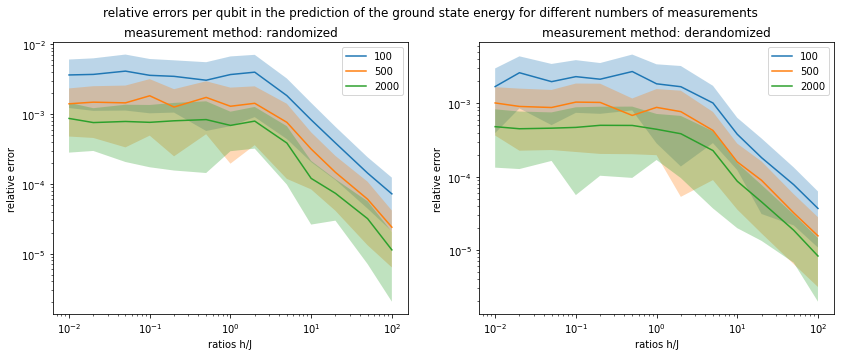

In [10]:
qubit_num = 14
num_of_measurements = np.array([100, 500, 2000])
batches = 50
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('relative errors per qubit in the prediction of the ground state energy for different numbers of measurements')
errors = np.zeros((batches, np.size(ratios_h_j)))
for l in range(0, 2):
    for i in range(0, np.size(num_of_measurements)):
        for j in range(0, np.size(ratios_h_j)):
            energy_brute = energy_dict[str(qubit_num)][str(ratios_h_j[j])][0]
            save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_heisenberg_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
            save_direc_index = Path('data/shadow_measurements/measurement_heisenberg_index_ratio_'+\
                              str(ratios_h_j[j])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
            measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
            measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
            measurements_dict = conversion_to_prediction_shadow_dict_shape(measurement_procedure[0:batches * num_of_measurements[i]],
                                                                          measurement_index[0:batches * num_of_measurements[i]], qubit_num)
            for b in range(0, batches):
                measurements = measurements_dict[b*num_of_measurements[i]:(b+1)*num_of_measurements[i]]
                energy_shadow = HeisenbergHamiltonainAntiferro(qubit_num,
                                                           ratios_h_j[j], 1, 'periodic').energy_shadow(None,
                                                                                                       num_of_measurements[i],
                                                                                                       measurement_methods[l], measurements)
                errors[b,j] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute) / qubit_num
        error_mean = np.mean(errors, axis= 0)
        error_std = np.std(errors, axis = 0)
        axs[l].errorbar(ratios_h_j, error_mean, label = num_of_measurements[i])
        axs[l].fill_between(ratios_h_j, error_mean - error_std, error_mean + error_std, alpha = 0.3)
        axs[l].set(xscale='log', yscale='log', xlabel='ratios h/J', ylabel = 'relative error')
        axs[l].set_title('measurement method: ' + str(measurement_methods[l]))
        axs[l].legend()

Now we plot the relative error against the number of samples for the three ratios
 $\frac{h}{J} \in \{0.1, 1, 10\}$. Again we calculate the mean and the standard deviation.

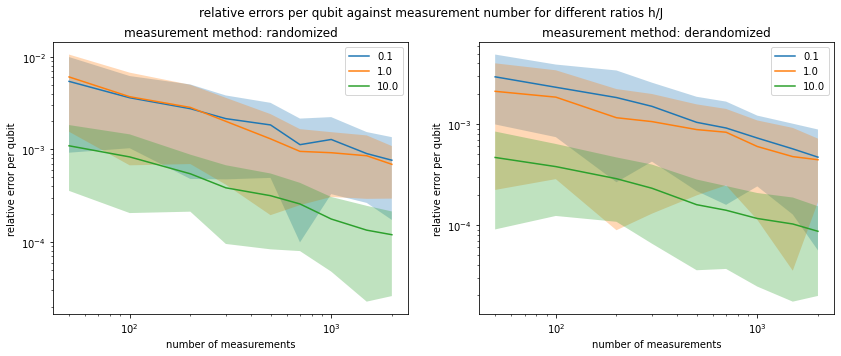

In [11]:
num_of_measurements = np.array([50, 100, 200, 300, 500, 700, 1000, 1500, 2000])
batches = 50
some_ratios = np.array([0.1, 1, 10])
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('relative errors per qubit against measurement number for different ratios h/J')
for l in range(0, 2):
    for i in range(0, np.size(some_ratios)):
        energy_shadow = np.zeros(np.size(num_of_measurements))
        errors = np.zeros((batches, np.size(num_of_measurements)))
        energy_brute = energy_dict[str(qubit_num)][str(some_ratios[i])][0] * np.ones(np.size(num_of_measurements))
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_heisenberg_ratio_'+\
                              str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_heisenberg_index_ratio_'+\
                              str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        for k in range(0, batches):
            for j in range(0, np.size(num_of_measurements)):
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]],
                                                                          measurement_index[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]], qubit_num)
                energy_shadow[j] = HeisenbergHamiltonainAntiferro(qubit_num,
                                                           some_ratios[i], 1, 'periodic').energy_shadow(None,
                                                                                                       num_of_measurements[j],
                                                                                                       measurement_methods[l], measurements)
            errors[k,:] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute) / qubit_num
        error_mean = np.mean(errors, axis=0)
        error_std = np.std(errors, axis=0)
        axs[l].errorbar(num_of_measurements, error_mean, label = some_ratios[i])
        axs[l].fill_between(num_of_measurements, error_mean - error_std, error_mean + error_std, alpha = 0.3)
        axs[l].set(xscale='log', yscale='log', xlabel='number of measurements', ylabel = 'relative error per qubit')
        axs[l].set_title('measurement method: ' + str(measurement_methods[l]))
        axs[l].legend()


We can see that $\frac{h}{J} = 1, 0.1$ behave approximately equally and for
$\frac{h}{J} = 10$ far less measurements are sufficient to achieve a good accuracy.

Now we fix the error and determine the number of samples needed to achieve it. We plot this
against the different ratios $\frac{h}{J}$. We choose the three different relative errors
$10^{-2}, 10^{-3}, 10^{-4}$. We compute mean and standard deviation using 50 batches.
We only say that a certain accuracy is reached if all later estimates using more samples also reach this accuracy.
This way we avoid cases where the error fluctuated below the error threshold but starts increasing again afterwards.

In [7]:
fixed_errors = np.array([1e-2, 1e-3, 1e-4])
batches = 50
sample_size_intervals = np.append(np.append(np.arange(1, 20, 1),np.arange(20, 500, 10)), np.arange(500, 2000, 50))
error_mean = np.zeros((np.size(sample_size_intervals), np.size(measurement_methods), np.size(ratios_h_j)))
error_std = np.zeros((np.size(sample_size_intervals), np.size(measurement_methods), np.size(ratios_h_j)))
error_list = np.zeros((batches, np.size(sample_size_intervals), np.size(measurement_methods), np.size(ratios_h_j)))
for l in range(0, 2):
    for i in range(0, np.size(ratios_h_j)):
        energy_shadow = np.zeros(np.size(sample_size_intervals))
        energy_brute = energy_dict[str(qubit_num)][str(ratios_h_j[i])][0] * np.ones(np.size(sample_size_intervals))
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_heisenberg_ratio_'+\
                              str(ratios_h_j[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_heisenberg_index_ratio_'+\
                              str(ratios_h_j[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        for k in range(0, batches):
            for j in range(0, np.size(sample_size_intervals)):
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[k*sample_size_intervals[j]:(k+1)*sample_size_intervals[j]],
                                                                          measurement_index[k*sample_size_intervals[j]:(k+1)*sample_size_intervals[j]], qubit_num)
                energy_shadow[j] = HeisenbergHamiltonainAntiferro(qubit_num,
                                                           ratios_h_j[i], 1, 'periodic').energy_shadow(None,
                                                                                                       sample_size_intervals[j],
                                                                                                       measurement_methods[l], measurements)
                error_list[k,:,l,i] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute) / qubit_num

save_direc_error_list = Path('data/shadow_measurements/error_list_heisenberg.npy')
np.save(save_direc_error_list, error_list)

In [8]:
save_direc_error_list = Path('data/shadow_measurements/error_list_heisenberg.npy')
error_list = np.load(save_direc_error_list, allow_pickle='TRUE')

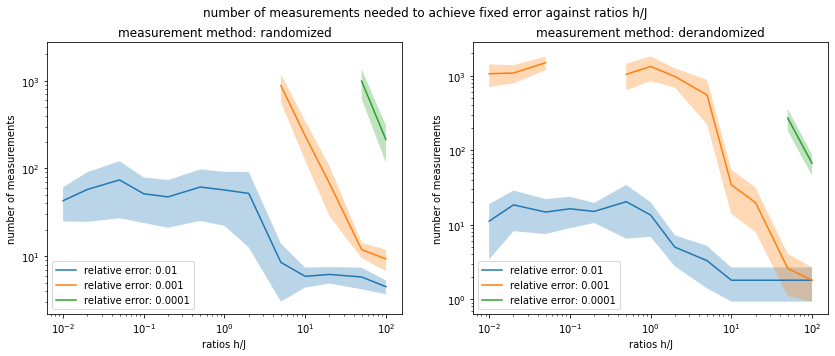

In [9]:
fixed_errors = np.array([1e-2, 1e-3, 1e-4])
batches = 10
sample_size_intervals = np.append(np.append(np.arange(1, 20, 1),np.arange(20, 500, 10)), np.arange(500, 2000, 50))
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('number of measurements needed to achieve fixed error against ratios h/J')

for l in range(0,2):
    for e in range(0, np.size(fixed_errors)):
        sample_size = np.zeros((batches, np.size(ratios_h_j)))
        for i in range(0, np.size(ratios_h_j)):
            for k in range(0, batches):
                pos = np.where(error_list[k,:,l,i] <= fixed_errors[e])[0]
                if pos.size == 0:
                    sample_size[k,i] = None
                else:
                    for p in range(0, pos.size):
                        if pos.size - p == np.size(sample_size_intervals[pos[p]:]):
                            sample_size[k,i] = sample_size_intervals[pos[p]]
                            break
                        if p == pos.size - 1:
                            sample_size[k,i] = None
        sample_size_mean = np.mean(sample_size, axis=0)
        sample_size_std = np.std(sample_size, axis=0)
        for rat in range(0, np.size(ratios_h_j)):
            for bat in range(0, batches):
               if sample_size[bat, rat] is None:
                    sample_size_mean[rat] = None
                    sample_size_std[rat] = None
        axs[l].errorbar(ratios_h_j, sample_size_mean, label = 'relative error: ' + str(fixed_errors[e]))
        axs[l].fill_between(ratios_h_j, sample_size_mean - sample_size_std, sample_size_mean + sample_size_std, alpha = 0.3)
        axs[l].legend()
        axs[l].set_title('measurement method: ' + str(measurement_methods[l]))
        axs[l].set(xscale='log', yscale='log', xlabel='ratios h/J', ylabel = 'number of measurements')


The rigorous performance guarantee for the scaling of our shadows states
that $N = \mathcal{O}(\frac{1}{\epsilon^2})$. We would like to see
how the accuracy scales in our experiment . It must perform
   at least as good as the performance guarantee states. We assume
a scaling of the form  $N = \frac{C}{\epsilon^a}$ where we want to
 determine $C$ and $a$ by least square fits for all ratios $\frac{h}{J}$.
At $\frac{h}{J} = 1$ a quantum phase transition happens. Speaking roughly, it
becomes difficult / takes a lot of measurements to predict properties of the
corresponding quantum ground state. We are close to a 'worst-case-scenario'.
Hence, it is reasonable to assume a scaling of the form $N = \frac{C}{\epsilon^a}$
in this region. Further away from $\frac{h}{J} = 1$ this relationship might break.
Taking the $\log$ on both sides gives:
    $ \log{N} = \log{C} - a \log{\epsilon}$.
However, it is computationally very expensive to determine
 $N(\epsilon)$ because we do not only need to find the
first $N$ for which $\epsilon < const.$ but the $N$ for which
$\epsilon < const. \forall M > N$. This means we would effectively have to
compute all values of $\epsilon(N)$ to find the correct $N$.
Therefore we invert the relationship which yields
$\log{\epsilon} = \frac{\log{C}}{a} - \frac{\log{N}}{a}$.
 This provides a less accurate fit but is computationally
 feasible for more batches. We get the error $\Delta \log{C}$ as fit result
but want $\Delta C$. We can compute $\Delta C$ using Gaussian error
propagation. $\Delta \log{C} = \frac{\Delta C}{C} \rightarrow
 \Delta C = C \Delta \log{C}$.

We determine the averaged $\epsilon$
and its standard deviation by using 50 measurement batches.

In [10]:
from scipy.optimize import curve_fit
def log_epsilon(num_measurements_log, const_log, exponent):
    return (const_log - num_measurements_log)/exponent

from scipy.stats import chi2

def compute_p_value_and_chi_red(data, params, data_std):
    chi2_sum = np.sum((np.exp(log_epsilon(np.log(num_of_measurements), params[0], params[1])) - data)**2/ data_std**2)
    dof = np.size(num_of_measurements) - 2
    chi2_red = chi2_sum / dof
    p_val = round(1 - chi2.cdf(chi2_sum, dof),2)*100
    return  p_val, chi2_red

randomized measurements, const = 0.008515704328705766 +- 0.003305620890100126
randomized measurements, exponent = 1.6805230152599906 +- 0.06303304759193495
randomized measurements, p_val = 100.0, chi_red = 0.015625254891295612
derandomized measurements, const = 6.170166599733459e-05 +- 5.1402876369042494e-05
derandomized measurements, exponent = 2.2413093529249775 +- 0.12163267547012352
derandomized measurements, p_val = 100.0, chi_red = 0.013531574877837134


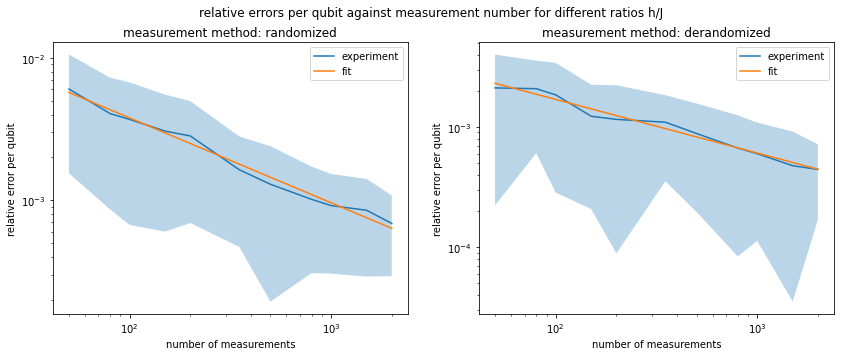

In [11]:
qubit_num = 14
num_of_measurements = np.array([50, 80, 100, 150, 200, 350, 500, 800, 1000, 1500, 2000])
batches = 50
some_ratios = np.array([1.0])
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('relative errors per qubit against measurement number for different ratios h/J')
for l in range(0, 2):
    for i in range(0, np.size(some_ratios)):
        energy_shadow = np.zeros(np.size(num_of_measurements))
        errors = np.zeros((batches, np.size(num_of_measurements)))
        energy_brute = energy_dict[str(qubit_num)][str(some_ratios[i])][0] * np.ones(np.size(num_of_measurements))
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_heisenberg_ratio_'+\
                              str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_heisenberg_index_ratio_'+\
                              str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        for k in range(0, batches):
            for j in range(0, np.size(num_of_measurements)):
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]],
                                                                          measurement_index[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]], qubit_num)
                energy_shadow[j] = HeisenbergHamiltonainAntiferro(qubit_num,
                                                           some_ratios[i], 1, 'periodic').energy_shadow(None,
                                                                                                       num_of_measurements[j],
                                                                                                       measurement_methods[l], measurements)
            errors[k,:] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute) / qubit_num
        error_mean = np.mean(errors, axis=0)
        error_std = np.std(errors, axis=0)
        popt, pcov = curve_fit(log_epsilon, np.log(num_of_measurements), np.log(error_mean), sigma=np.log(error_std))
        p_val, chi_red = compute_p_value_and_chi_red(error_mean, popt, error_std)
        print(measurement_methods[l] + ' measurements, const = ' + str(np.exp(popt[0])) + ' +- ' + str(np.exp(popt[0]) * np.sqrt(pcov[0][0])))
        print(measurement_methods[l] + ' measurements, exponent = ' + str(popt[1]) + ' +- ' + str(np.sqrt(pcov[1][1])))
        print(measurement_methods[l] + ' measurements, p_val = ' + str(p_val) + ', chi_red = ' + str(chi_red))
        axs[l].errorbar(num_of_measurements, error_mean, label = 'experiment')
        axs[l].fill_between(num_of_measurements, error_mean - error_std, error_mean + error_std, alpha = 0.3)
        axs[l].errorbar(num_of_measurements, np.exp(log_epsilon(np.log(num_of_measurements),popt[0], popt[1])), label='fit')
        axs[l].set(xscale='log', yscale='log', xlabel='number of measurements', ylabel = 'relative error per qubit')
        axs[l].set_title('measurement method: ' + str(measurement_methods[l]))
        axs[l].legend()

The formula we
gave for the
performance guarantee of the randomized classical shadows might not be valid for the
derandomized classical shadows. We investigate this by doing
a statistical hypothesis test to see whether the fitting function really
describes the data well. We use the $\chi^2$ distribution to compute the p-value. The
p-value describes the probability to obtain a higher $\chi^2$ value if one performs the
measurement again. Thus, ideally $p=0.5$ .

 $\chi^2$ is given by:

\begin{equation}
\chi ^2 = \sum_{i=1}^{d} \frac{(\epsilon_i - \hat{\epsilon}(N_i,C,a))^2}{\sigma_i^2}
\end{equation}

where $d$ is the number of datapoints, $\hat{\epsilon}(N,C,a)$ our fitfunction with the
ideal values we just found, the $\epsilon_i$ are our datapoints / mean errors and the $\sigma_i$
are the standard deviations of the $\epsilon_i$ datapoints.

In both cases we obtain p-values of 100% which means that we either drastically overfit
or that the standard deviation we computed is way too big. The later might be the case
because the standard deviation keeps becoming smaller the more batches we use to
determine it.

Now we would like to compute this for every ratio $\frac{h}{J}$ and plot both the
constant $C$ and the exponent $a$ against the different ratios $\frac{h}{J}$.

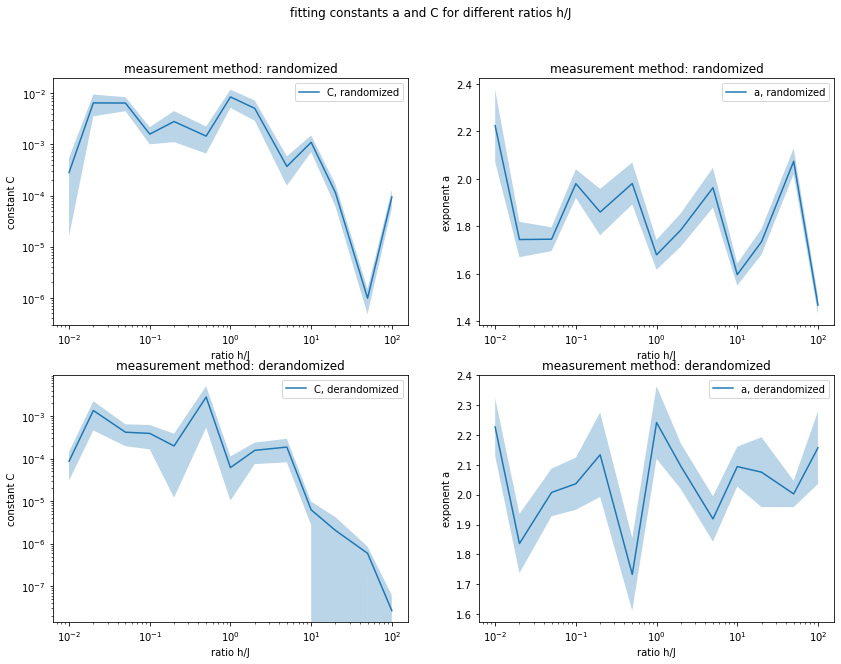

In [13]:
num_of_measurements = np.array([50, 80, 100, 150, 200, 350, 500, 800, 1000, 1500, 2000])
batches = 50
some_ratios = np.array([0.01, 0.02, 0.05, 0.1,
                           0.2, 0.5, 1, 2, 5, 10, 20, 50, 100], dtype=float)
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(14)
fig.suptitle('fitting constants a and C for different ratios h/J')
for l in range(0, 2):
    const = np.zeros(np.size(some_ratios))
    const_err = np.zeros(np.size(some_ratios))
    exponent_a = np.zeros(np.size(some_ratios))
    exponent_a_err = np.zeros(np.size(some_ratios))
    for i in range(0, np.size(some_ratios)):
        energy_shadow = np.zeros(np.size(num_of_measurements))
        errors = np.zeros((batches, np.size(num_of_measurements)))
        energy_brute = energy_dict[str(qubit_num)][str(some_ratios[i])][0] * np.ones(np.size(num_of_measurements))
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_heisenberg_ratio_'+\
                              str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_heisenberg_index_ratio_'+\
                              str(some_ratios[i])+'_qubit_num_'+str(qubit_num)+'_method_'+measurement_methods[l]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        for k in range(0, batches):
            for j in range(0, np.size(num_of_measurements)):
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]],
                                                                          measurement_index[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]], qubit_num)
                energy_shadow[j] = HeisenbergHamiltonainAntiferro(qubit_num,
                                                           some_ratios[i], 1, 'periodic').energy_shadow(None,
                                                                                                       num_of_measurements[j],
                                                                                                       measurement_methods[l], measurements)
            errors[k,:] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute) / qubit_num
        error_mean = np.mean(errors, axis=0)
        error_std = np.std(errors, axis=0)
        popt, pcov = curve_fit(log_epsilon, np.log(num_of_measurements), np.log(error_mean), sigma=np.log(error_std))
        const[i] = np.exp(popt[0])
        const_err[i] = np.exp(popt[0]) * np.sqrt(pcov[0][0])
        exponent_a[i] = popt[1]
        exponent_a_err[i] = np.sqrt(pcov[1][1])
    axs[l, 0].errorbar(some_ratios, const, label = 'C' + ', ' + measurement_methods[l])
    axs[l, 0].fill_between(some_ratios, const - const_err, const +  const_err, alpha = 0.3)
    axs[l, 0].set(xscale = 'log', yscale = 'log', xlabel='ratio h/J', ylabel = 'constant C')
    axs[l, 0].set_title('measurement method: ' + str(measurement_methods[l]))
    axs[l, 0].legend()
    axs[l, 1].errorbar(some_ratios, exponent_a, label = 'a' + ', ' + measurement_methods[l])
    axs[l, 1].fill_between(some_ratios, exponent_a - exponent_a_err, exponent_a + exponent_a_err, alpha = 0.3)
    axs[l, 1].set(xscale = 'log' ,xlabel='ratio h/J', ylabel = 'exponent a')
    axs[l, 1].set_title('measurement method: ' + str(measurement_methods[l]))
    axs[l, 1].legend()